# Color Selection

Let’s code up a simple color selection in Python.

No need to download or install anything, you can just follow along in the browser for now.

We'll be working with the same image you saw previously.

Check out the code below. First, I import pyplot and image from matplotlib. I also import numpy for operating on the image.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

I then read in an image and print out some stats. I’ll grab the x and y sizes and make a copy of the image to work with. NOTE: Always make a copy of arrays or other variables in Python. If instead, you say "a = b" then all changes you make to "a" will be reflected in "b" as well!

In [3]:
# Read in the image and print out some stats
image = mpimg.imread('test.jpg')
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
## 주의! x축(가로) = 2차원 배열의 두번쨰 요소의 개수
##       y축(세로) = 2차원 배열의 첫번째 요소의 개수
ysize = image.shape[0]
xsize = image.shape[1]
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


Next I define a color threshold in the variables red_threshold, green_threshold, and blue_threshold and populate rgb_threshold with these values. This vector contains the minimum values for red, green, and blue (R,G,B) that I will allow in my selection.

In [4]:
# Define our color selection criteria
red_threshold = 220
green_threshold = 220
blue_threshold = 220
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

Next, I'll select any pixels below the threshold and set them to zero.

After that, all pixels that meet my color criterion (those above the threshold) will be retained, and those that do not (below the threshold) will be blacked out.

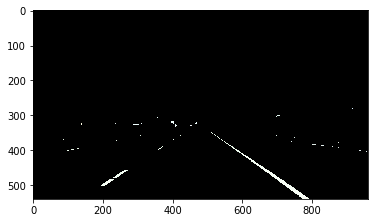

In [5]:
# Do a boolean or with the "|" character to Identify pixels below the threshold
## RGB 각각의 threshold 미만 값에 해당하는 pixel bit 연산 or로 찾기
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
## threshold 미만 픽셀의 RGB값 0로 만들기
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)
plt.show()

The result, color_select, is an image in which pixels that were above the threshold have been retained, and pixels below the threshold have been blacked out.

In the code snippet above, red_threshold, green_threshold and blue_threshold are all set to 0, which implies all pixels will be included in the selection.

In the next quiz, you will modify the values of red_threshold, green_threshold and blue_threshold until you retain as much of the lane lines as possible while dropping everything else. Your output image should look like the one below.


Image after color selection

# Region of Interest Mask
Awesome! Now you've seen that with a simple color selection we have managed to eliminate almost everything in the image except the lane lines.

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

Check out the code below. The variables left_bottom, right_bottom, and apex represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but later you'll use a quadrilateral, and in principle, you could use any polygon.

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


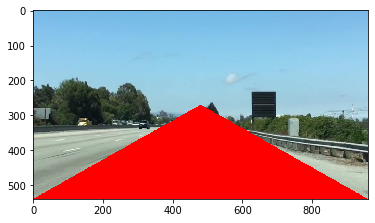

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image and print some stats
image = mpimg.imread('test.jpg')
print('This image is: ', type(image), 
         'with dimensions:', image.shape)

# Pull out the x and y sizes and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# [x(가로), y(세로)], apex = 소실점을 써야할 것 같음
left_bottom = [0, 539]              
right_bottom = [959, 539]
apex = [480, 270]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
## np.polyfit(x좌표 array, y좌표 array, deg - 함수의 차수(1차함수, 2차 함수 등등))
## -> return : array([deg 계수, deg - 1 계수, ... , 상수항])
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
## np.meshgrid(x1, x2...., xn, copy=True, sparse=False, indexing='xy')
## parameter : x1, x2... xn : 1D-array like
## return : X1(n-dimensional array), X2, XN 
### ex)
### XX, YY = meshgrid([0, 1, 2], [0, 1])
### > XX = ([0, 1, 2],
###         [0, 1, 2])
### > YY = ([0, 0, 0],
###         [1, 1, 1])
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255, 0, 0]

# Display the image
plt.imshow(region_select)

# uncomment if plot does not display
# plt.show()

# Combining Color and Region Selections
Now you've seen how to mask out a region of interest in an image. Next, let's combine the mask and color selection to pull only the lane lines out of the image.

Check out the code below. Here we’re doing both the color and region selection steps, requiring that a pixel meet both the mask and color selection requirements to be retained.

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


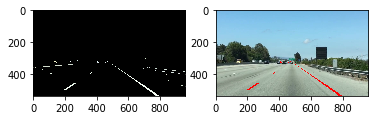

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test.jpg')
print('This image is: ', type(image), 
         'with dimensions:', image.shape)

# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest (Note: if you run this code, 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz ;)
left_bottom = [0, 539]
right_bottom = [959, 539]
apex = [480, 270]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
# Mask color selection
color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

# Display our two output images
plt.subplot(1, 2, 1)
plt.imshow(color_select)
plt.subplot(1, 2, 2)
plt.imshow(line_image)

# uncomment if plot does not display
# plt.show()

# Canny Edge Detection in Action
Now that you have a conceptual grasp on how the Canny algorithm works, it's time to use it to find the edges of the lane lines in an image of the road. So let's give that a try.

First, we need to read in an image:

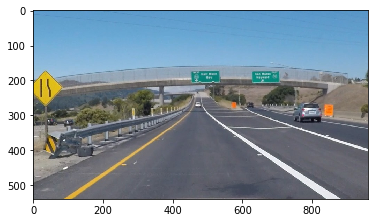

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('exit-ramp.jpg')
plt.imshow(image)

Here we have an image of the road, and it's fairly obvious by eye where the lane lines are, but what about using computer vision?

Let's go ahead and convert to grayscale.

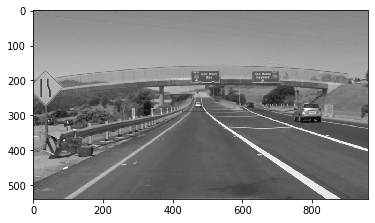

In [23]:
import cv2  #bringing in OpenCV libraries
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

Let’s try our Canny edge detector on this image. This is where OpenCV gets useful.

First, we'll have a look at the parameters for the OpenCV Canny function. You will call it like this:

**edges = cv2.Canny(gray, low_threshold, high_threshold)**

In this case, you are applying Canny to the image gray and your output will be another image called edges. low_threshold and high_threshold are your thresholds for edge detection.

The algorithm will 
First detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold.   
Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges.  
The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else.  
See the OpenCV Canny Docs for more details.  

What would make sense as a reasonable range for these parameters?  
In our case, converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values.  
Hence, the pixel values range from 0 to 255.

This range implies that derivatives (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds. So, a reasonable range for your threshold parameters would also be in the tens to hundreds.

As far as a ratio of low_threshold to high_threshold, John Canny himself recommended a low to high ratio of 1:2 or 1:3.

We'll also include Gaussian smoothing, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging (check out the OpenCV docs for GaussianBlur). cv2.Canny() actually applies Gaussian smoothing internally, but we include it here because you can get a different result by applying further smoothing (and it's not a changeable parameter within cv2.Canny()!).

You can choose the kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area. The example in the previous lesson was kernel_size = 3.

Note: If this is all sounding complicated and new to you, don't worry! We're moving pretty fast through the material here, because for now we just want you to be able to use these tools. 
**If you would like to dive into the math underpinning these functions, please check out the free Udacity course, Intro to Computer Vision, where the third lesson covers Gaussian filters and the sixth and seventh lessons cover edge detection.**

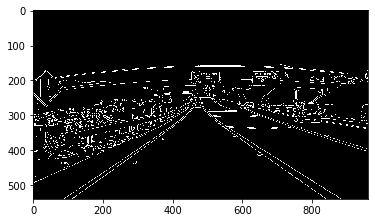

In [31]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
image = mpimg.imread('exit-ramp.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')

# Hough Transform on Edge Detected Image
Now you know how the Hough Transform works, but to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.).

To do this, we'll be using an OpenCV function called **HoughLinesP** that takes several parameters. Let's code it up and find the lane lines in the image we detected edges in with the Canny function (for a look at coding up a Hough Transform from scratch, check [this](https://alyssaq.github.io/2014/understanding-hough-transform/) out.)

Here's the image we're working with:
<img src="edges-exitramp.jpg">

Let's look at the input parameters for the OpenCV function **HoughLinesP** that we will use to find lines in the image. You will call it like this:

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)  

In this case, we are operating on the image **masked_edges** (the output from Canny) and the output **from HoughLinesP** will be **lines**, which will simply be an array containing the endpoints (x1, y1, x2, y2) of all line segments detected by the transform operation. The other parameters define just what kind of line segments we're looking for.

First off, **rho** and **theta** are the distance and angular resolution of our grid in Hough space. Remember that, in Hough space, we have a grid laid out along the (Θ, ρ) axis. You need to specify **rho** in units of pixels and **theta** in units of radians.
<img src="HoughSpace_Polar.jpg">

So, what are reasonable values? Well, rho takes a minimum value of 1, and a reasonable starting place for theta is 1 degree (pi/180 in radians). Scale these values up to be more flexible in your definition of what constitutes a line.

The **threshold** parameter specifies the minimum number of votes (intersections in a given grid cell) a candidate line needs to have to make it into the output. The empty **np.array([])** is just a placeholder, no need to change it. **min_line_length** is the minimum length of a line (in pixels) that you will accept in the output, and **max_line_gap** is the maximum distance (again, in pixels) between segments that you will allow to be connected into a single line. You can then iterate through your output **lines** and draw them onto the image to see what you got!

So, here's what its going to look like:

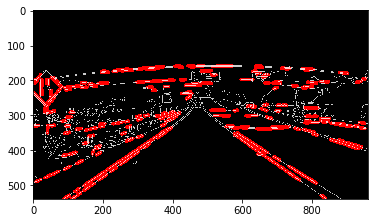

In [35]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in and grayscale the image
image = mpimg.imread('exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

As you can see I've detected lots of line segments! Your job, in the next exercise, is to figure out which parameters do the best job of optimizing the detection of the lane lines. Then, you'll want to apply a region of interest mask to filter out detected line segments in other areas of the image. Earlier in this lesson you used a triangular region mask, but this time you'll get a chance to use a quadrilateral region mask using the **cv2.fillPoly()** function (keep in mind though, you could use this same method to mask an arbitrarily complex polygon region). When you're finished you'll be ready to apply the skills you've learned to do the project at the end of this lesson.

## Quiz : Hough Transform

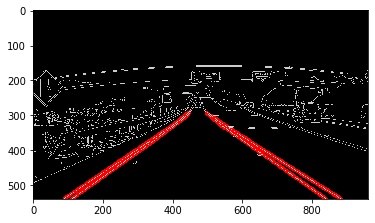

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


# Read in and grayscale the image
image = mpimg.imread('exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

# Tuning Parameters
Parameter tuning is one of the biggest challenges in computer vision - what works well for one image may not work at all with different lighting and/or backgrounds.

Computer Vision Engineers gain an intuition over time for ranges of parameters and different techniques that might work best for a set of situations. When getting started, this can be a big hill to climb. Oftentimes, building a tool to help speed up your iteration between different techniques and thresholds can help you in parameter tuning.

While it's not required for the project, you might consider reading [this blog post](https://medium.com/@maunesh/finding-the-right-parameters-for-your-computer-vision-algorithm-d55643b6f954) from a fellow Self-Driving Car student on their approach to a parameter tuning tool, and consider building one of your own in the future!